# Natural Language Processing with Disaster Tweets

Twitter or X has become an important communication channel in times of emergency.

The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

However many tweets has metaphorical terms like 'sky was blaze', 'its fire!', and so on which are actually common expressions in languages. Due to this it may be difficult to identify tweets related to real emergency.

For this project, our goal is to try solving the above problem by providing a Machine Learning Model.

Dataset has been obtained from this kaggle competition: https://www.kaggle.com/competitions/nlp-getting-started/overview

Dataset contains more than 10,000 tweets which were hand classified. 7613 of the Tweets have been provided as Training dataset with labels and 3263 tweets are provided as Test Dataset with no label. Our goal is to create a Bidirectional RNN based on both LSTM and GRU and compare the result against the test data by providing submission to the Kaggle Competition which gives out the F1 score. 

This project is divided into following parts:
1. Packages
2. EDA
3. Preprocessing
4. Model Creation, Hyperparameter Tuning, and Model Training
5. Model Evaluation
6. Conclusion

## 1. Packages

In [112]:
import numpy as np # linear algebra
import pandas as pd
import os

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as tfl

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 2. EDA

For the EDA we will analyse the data sets provided to us, especially the train dataset. While data has been cleaned and errors have been removed we will perform preprocessing steps for Model fitting after the basic EDA.

In [113]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [114]:
print('Training Dataset Shape:', train_df.shape)
print('Test Dataset Shape:', test_df.shape)
print('Submission Shape:', submission.shape)

Training Dataset Shape: (7613, 5)
Test Dataset Shape: (3263, 4)
Submission Shape: (3263, 2)


In [115]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [116]:
train_df.describe

<bound method NDFrame.describe of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w.

There are a lot of NaN values, however they are from the columns keyword and location. Data from these columns had been removed from the source for anonymity purposes.

For our model training we don't need id, keyword, and location columns. We will remove them in later steps and focus specifically on text and labels.

In [117]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


As we can confirm, we have not been provided with Text labels. Due to this we can't use Confusion metrics as we don't know real test labels. But still we will evaluate model performance by using the F1 score obtained by submission at Kaggle.

In [118]:
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


Now we will create an additional column to observe the length of tweets.

In [11]:
train_df['tweet_len'] = train_df['text'].apply(lambda x: len(x.split(' ')))

In [12]:
max(train_df['tweet_len'])

54

In [13]:
train_df['tweet_len'].value_counts()

17    494
18    484
11    481
14    474
16    435
13    423
12    422
15    420
20    405
19    402
9     375
10    332
21    303
8     294
22    271
7     236
23    228
24    187
6     186
5     161
25    131
4     111
26    100
3      75
27     68
28     42
2      41
29     14
1       8
30      6
31      3
54      1
Name: tweet_len, dtype: int64

Longest tweet contains 54 words but most of the tweets contain less than 20 words overall.

In [14]:
train_df['target'].value_counts(normalize = True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [16]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

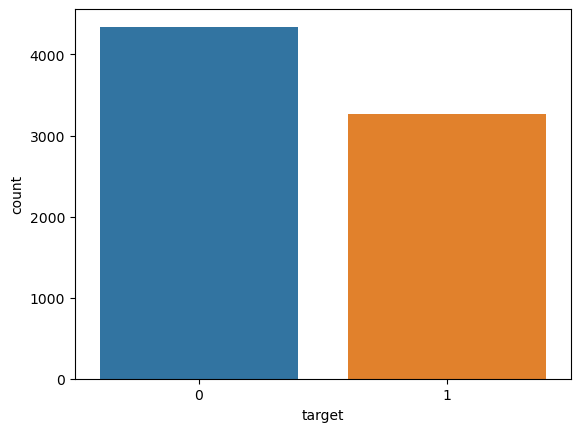

In [18]:
sns.countplot(x = train_df['target'])
plt.show()

In above cells we checked if dataset is unbalanced or not. Around 57% of the tweets are not related to Emergencies and around 43% of the tweets in training dataset does relate to emergencies. While there exist sligh imbalance its not big enough for us to try further steps to reduce it.

## 3. Preprocessing

Actually some earlier parts of preprocessing can be shifted to EDA but we grouped them together to focus preprocessing specifically.

Here we will clean the tweet texts by removing special characters and links to other websites among few other cleaning steps. After obtaining cleaned tweets we will remove the stopwords and then apply lemmatization.

With this we will have truncated good quality text, we will then tokenize it and add padding so that we can feed the input to the LSTM/GRU Model.

In [19]:
train_model = train_df[['text', 'target']]
test_model = test_df['text']

In [21]:
train_text = np.array(train_model['text'])
train_labels = np.array(train_model['target'])

In [22]:
test_text = np.array(test_model)

In [23]:
def clean_text(text):
    """
    Function for cleaning the tweets
    """
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

In [24]:
train_text = np.array([clean_text(text) for text in train_text])

In [25]:
train_text[:5]

array(['our deeds are the reason of this earthquake may allah forgive us all',
       'forest fire near la ronge sask canada',
       'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected',
       ' people receive wildfires evacuation orders in california ',
       'just got sent this photo from ruby alaska as smoke from wildfires pours into a school '],
      dtype='<U143')

In [26]:
test_text = np.array([clean_text(text) for text in test_text])

In [27]:
test_text[:5]

array(['just happened a terrible car crash',
       'heard about earthquake is different cities stay safe everyone',
       'there is a forest fire at spot pond geese are fleeing across the street i cannot save them all',
       'apocalypse lighting spokane wildfires',
       'typhoon soudelor kills  in china and taiwan'], dtype='<U144')

Now we will remove the stopwords.

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [30]:
train_text = np.array([remove_stopwords(text) for text in train_text])
train_text[:5]

array(['deeds reason earthquake may allah forgive us',
       'forest fire near la ronge sask canada',
       'residents asked shelter place notified officers evacuation shelter place orders expected',
       ' people receive wildfires evacuation orders california ',
       'got sent photo ruby alaska smoke wildfires pours school '],
      dtype='<U138')

In [31]:
test_text = np.array([remove_stopwords(text) for text in test_text])
test_text[:5]

array(['happened terrible car crash',
       'heard earthquake different cities stay safe everyone',
       'forest fire spot pond geese fleeing across street cannot save',
       'apocalypse lighting spokane wildfires',
       'typhoon soudelor kills  china taiwan'], dtype='<U125')

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word. One example of this process will be to convert word 'better' into 'good'. 

With Lemmatization we will reduce the overall vocabulary by converting words to their basic meaning.

In [32]:
lemmatizer = spacy.load("en_core_web_sm")

def lemmatization(sentence):
    doc = lemmatizer(str(sentence))
    lemmatized_sentence = " ".join([token.lemma_ for token in doc])
    return lemmatized_sentence

In [33]:
train_text = np.array([lemmatization(text) for text in train_text])
train_text[:5]

array(['deed reason earthquake may allah forgive we',
       'forest fire near la ronge sask canada',
       'resident ask shelter place notify officer evacuation shelter place order expect',
       '  people receive wildfire evacuation order california',
       'got send photo ruby alaska smoke wildfire pour school'],
      dtype='<U137')

In [34]:
test_text = np.array([lemmatization(text) for text in test_text])
test_text[:5]

array(['happen terrible car crash',
       'hear earthquake different city stay safe everyone',
       'forest fire spot pond geese flee across street can not save',
       'apocalypse light spokane wildfire',
       'typhoon soudelor kills   china taiwan'], dtype='<U122')

Now we will Tokenize the training and test dataset. This will become the input of the model after adding some padding.

In [36]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_text)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

14887

In [37]:
train_sequences = word_tokenizer.texts_to_sequences(train_text)
test_sequences = word_tokenizer.texts_to_sequences(test_text)
print(train_sequences[0])

[3644, 467, 205, 87, 1446, 1769, 39]


In [38]:
longest_train = max(train_text, key=lambda sentence: len(word_tokenize(sentence)))
length_long_train = len(word_tokenize(longest_train))
print(longest_train)
print(length_long_train)

rite man tlk widout nuh curfew long side aka cum fi steal di show itz rubbery di whole dem fi knw sound music
23


In [39]:
train_sequences_pad = pad_sequences(
    train_sequences, maxlen = length_long_train, padding='post'
)
test_sequences_pad = pad_sequences(
    test_sequences, maxlen = length_long_train, padding='post'
)
train_sequences_pad

array([[3644,  467,  205, ...,    0,    0,    0],
       [ 148,    4,  188, ...,    0,    0,    0],
       [1447,  503, 1770, ...,    0,    0,    0],
       ...,
       [ 498,  441, 1310, ...,    0,    0,    0],
       [  32,  793, 2596, ...,    0,    0,    0],
       [ 136,   34,  385, ...,    0,    0,    0]], dtype=int32)

## 4. Model Creation, Hyperparameter Tuning, and Model Training

In this part we will create skeleton of the models, discuss hyperparameter tuning, and fit the model with the training dataset.

We have decided to use Recurrent Neural Network as they are good in modeling recurrent data and tweets are one of form of that type of data. Among different architectures of RNN we are using both Long Short Term Memory or LSTM Model and GRU Model. Both of them uses cell memory states to store the long term memory.

We also used bidirectional form of both of them so that we can use the memory of forward words too. 

In [40]:
train_labels

array([1, 1, 1, ..., 1, 1, 1])

In [41]:
X_train, X_val, y_train, y_val = train_test_split(
    train_sequences_pad, train_labels, test_size=0.2, random_state = 10, shuffle = True
)


In [77]:
max_length = 23

# Hyperparameters
embedding_dim = 200 #Tested 150,200, and 250. Picked 200 as there was not much difference
vocab_size = 15000 #Tested 10,000 and 15,000. Picked 15,000 as its near the vocabulary size and is better
# in training
epochs = 8 #Tested 5,10,20, and 8. Picked 8 as after this Validation loss/Accuracy is converging
learning_rate = 0.002 #Tested 0.001, 0.002, and 0.003. Picked 0.002.

Here we have taken max_length fix as 23 as its the length of the longest tokenized tweet. Besides this all the above variables are hyperparameters. 

Above cells contain values of hyperparameters we have chosen after checking various combinations of hyperparameters. We have performed hyperparameter tuning by testing the different combinations on both LSTM and GRU Models. Reader can change the values above and run the cells below to check it themseleves. 

Embedding Dim did not effect both of the models much.

Vocab Size of 15,000 worked better in both of the models. Its also close to the real vocabulary dictionary tweets contained.

We have tested a lot of number of Epochs and picked 8 as the most optimum number. This finding was same for both LSTM and GRU model.

We have chosen Adam as the Optimizer for both model. We tested 0.001, 0.002, and 0.003 as the learning rates for both models, there is not much difference besides early converging to the training metrics in higher learning rate. We have chosen 0.002 as our learning rate for both of the models.

In [78]:
# LSTM Model with best set of Hyperparameters
model_lstm = tf.keras.Sequential([
    tfl.Embedding(vocab_size, embedding_dim, input_length = max_length),
    
    tfl.Bidirectional(tfl.LSTM(max_length*2, return_sequences = True, recurrent_dropout = 0.1)),
    tfl.GlobalMaxPool1D(),
    tfl.BatchNormalization(),
    tfl.Dropout(0.5),
                      
    tfl.Dense(units = max_length, activation = "relu"),
    tfl.Dropout(0.5),
    
    tfl.Dense(units = max_length, activation = "relu"),
    tfl.Dropout(0.5),
    
    tfl.Dense(units = 1, activation = 'sigmoid')
])

model_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 23, 200)           3000000   
                                                                 
 bidirectional_7 (Bidirectio  (None, 23, 92)           90896     
 nal)                                                            
                                                                 
 global_max_pooling1d_7 (Glo  (None, 92)               0         
 balMaxPooling1D)                                                
                                                                 
 batch_normalization_7 (Batc  (None, 92)               368       
 hNormalization)                                                 
                                                                 
 dropout_21 (Dropout)        (None, 92)                0         
                                                      

In [79]:
model_lstm.compile(
    loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    , metrics=['accuracy']
)

In [48]:
#Please uncomment for Epochs = 10

# history_lstm = model_lstm.fit(X_train, y_train,
#                               epochs = 10,
#                               validation_data=(X_val, y_val))

Epoch 1/10
191/191 [==============================] - 46s 237ms/step - loss: 0.5505 - accuracy: 0.7350 - val_loss: 0.5757 - val_accuracy: 0.7649
Epoch 2/10
191/191 [==============================] - 40s 210ms/step - loss: 0.4051 - accuracy: 0.8310 - val_loss: 0.5103 - val_accuracy: 0.7656
Epoch 3/10
191/191 [==============================] - 39s 204ms/step - loss: 0.2813 - accuracy: 0.9002 - val_loss: 0.5706 - val_accuracy: 0.7754
Epoch 4/10
191/191 [==============================] - 40s 207ms/step - loss: 0.2209 - accuracy: 0.9236 - val_loss: 0.6833 - val_accuracy: 0.7518
Epoch 5/10
191/191 [==============================] - 39s 205ms/step - loss: 0.1781 - accuracy: 0.9458 - val_loss: 0.8559 - val_accuracy: 0.7472
Epoch 6/10
191/191 [==============================] - 39s 205ms/step - loss: 0.1222 - accuracy: 0.9594 - val_loss: 1.1406 - val_accuracy: 0.7557
Epoch 7/10
191/191 [==============================] - 41s 214ms/step - loss: 0.1008 - accuracy: 0.9640 - val_loss: 1.5443 - val_ac

In [53]:
#Please uncomment to try for Epochs = 20

# history_lstm_20 = model_lstm.fit(X_train, y_train,
#                               epochs = 20,
#                               initial_epoch = history_lstm.epoch[-1],
#                               validation_data = (X_val, y_val))

Epoch 10/20
191/191 [==============================] - 38s 198ms/step - loss: 0.0826 - accuracy: 0.9691 - val_loss: 1.5394 - val_accuracy: 0.7518
Epoch 11/20
191/191 [==============================] - 38s 199ms/step - loss: 0.0983 - accuracy: 0.9683 - val_loss: 1.2461 - val_accuracy: 0.7708
Epoch 12/20
191/191 [==============================] - 38s 198ms/step - loss: 0.0808 - accuracy: 0.9703 - val_loss: 1.7938 - val_accuracy: 0.7511
Epoch 13/20
191/191 [==============================] - 37s 195ms/step - loss: 0.0614 - accuracy: 0.9754 - val_loss: 1.9415 - val_accuracy: 0.7669
Epoch 14/20
191/191 [==============================] - 38s 200ms/step - loss: 0.0653 - accuracy: 0.9762 - val_loss: 1.5446 - val_accuracy: 0.7669
Epoch 15/20
191/191 [==============================] - 38s 197ms/step - loss: 0.0642 - accuracy: 0.9755 - val_loss: 1.9758 - val_accuracy: 0.7656
Epoch 16/20
191/191 [==============================] - 37s 195ms/step - loss: 0.0653 - accuracy: 0.9754 - val_loss: 1.5545 -

In [80]:
# LSTM model training with best set of Hyperparameters
history_lstm = model_lstm.fit(X_train, y_train,
                               epochs = epochs,
                               validation_data=(X_val, y_val))

Epoch 1/8
191/191 [==============================] - 54s 249ms/step - loss: 0.6274 - accuracy: 0.6522 - val_loss: 0.6431 - val_accuracy: 0.6993
Epoch 2/8
191/191 [==============================] - 38s 198ms/step - loss: 0.4458 - accuracy: 0.8146 - val_loss: 0.5175 - val_accuracy: 0.7741
Epoch 3/8
191/191 [==============================] - 37s 192ms/step - loss: 0.3059 - accuracy: 0.8933 - val_loss: 0.5166 - val_accuracy: 0.7768
Epoch 4/8
191/191 [==============================] - 38s 198ms/step - loss: 0.2056 - accuracy: 0.9278 - val_loss: 0.7812 - val_accuracy: 0.7649
Epoch 5/8
191/191 [==============================] - 37s 195ms/step - loss: 0.1503 - accuracy: 0.9527 - val_loss: 1.6020 - val_accuracy: 0.7249
Epoch 6/8
191/191 [==============================] - 37s 191ms/step - loss: 0.1445 - accuracy: 0.9570 - val_loss: 1.0692 - val_accuracy: 0.7452
Epoch 7/8
191/191 [==============================] - 36s 187ms/step - loss: 0.1112 - accuracy: 0.9640 - val_loss: 1.0251 - val_accuracy:

In [81]:
#GRU Model with best set of Hyperparameters

model_gru = tf.keras.Sequential([
    tfl.Embedding(vocab_size, embedding_dim, input_length = max_length),
    
    tfl.Bidirectional(tfl.GRU(max_length*2, return_sequences = True, recurrent_dropout = 0.1)),
    tfl.GlobalMaxPool1D(),
    tfl.BatchNormalization(),
    tfl.Dropout(0.5),
                      
    tfl.Dense(units = max_length, activation = "relu"),
    tfl.Dropout(0.5),
    
    tfl.Dense(units = max_length, activation = "relu"),
    tfl.Dropout(0.5),
    
    tfl.Dense(units = 1, activation = 'sigmoid')
])

model_gru.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 23, 200)           3000000   
                                                                 
 bidirectional_8 (Bidirectio  (None, 23, 92)           68448     
 nal)                                                            
                                                                 
 global_max_pooling1d_8 (Glo  (None, 92)               0         
 balMaxPooling1D)                                                
                                                                 
 batch_normalization_8 (Batc  (None, 92)               368       
 hNormalization)                                                 
                                                                 
 dropout_24 (Dropout)        (None, 92)                0         
                                                      

In [82]:
model_gru.compile(
    loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    metrics=['accuracy']
)

In [83]:
#Fititng GRU model with the chosen set of Hyperparameters

history_gru = model_gru.fit(X_train, y_train,
         epochs = epochs,
         validation_data=(X_val, y_val))

Epoch 1/8
191/191 [==============================] - 53s 237ms/step - loss: 0.6764 - accuracy: 0.5926 - val_loss: 0.6531 - val_accuracy: 0.5936
Epoch 2/8
191/191 [==============================] - 36s 190ms/step - loss: 0.5043 - accuracy: 0.7749 - val_loss: 0.5056 - val_accuracy: 0.7663
Epoch 3/8
191/191 [==============================] - 35s 184ms/step - loss: 0.3535 - accuracy: 0.8701 - val_loss: 0.4823 - val_accuracy: 0.7722
Epoch 4/8
191/191 [==============================] - 34s 176ms/step - loss: 0.2538 - accuracy: 0.9122 - val_loss: 0.5924 - val_accuracy: 0.7722
Epoch 5/8
191/191 [==============================] - 36s 189ms/step - loss: 0.1953 - accuracy: 0.9389 - val_loss: 0.8589 - val_accuracy: 0.7768
Epoch 6/8
191/191 [==============================] - 34s 178ms/step - loss: 0.1374 - accuracy: 0.9570 - val_loss: 0.9805 - val_accuracy: 0.7656
Epoch 7/8
191/191 [==============================] - 35s 182ms/step - loss: 0.1239 - accuracy: 0.9614 - val_loss: 1.3050 - val_accuracy:

Now we have created the model, tuned the hyperparameters, and even trained the models with the Training dataset. In next step we will evaluate both of the models.

## 5. Model Evaluation

For model evaluation we will observe the recorded Loss and Accuracy for Test and Vadidation data set for both models and use the F1 score obtained by submitting both of the models seperately in the Kaggle Competition.

In [94]:
print('LSTM Training Loss:', history_lstm.history['loss'][-1])
print('LSTM Training Accuracy:', history_lstm.history['accuracy'][-1])
print('LSTM Validation Loss:', history_lstm.history['val_loss'][-1])
print('LSTM Validation Accuracy:', history_lstm.history['val_accuracy'][-1])

LSTM Training Loss: 0.09362120181322098
LSTM Training Accuracy: 0.9674876928329468
LSTM Validation Loss: 1.085390567779541
LSTM Validation Accuracy: 0.7491792440414429


In [95]:
print('GRU Training Loss:', history_gru.history['loss'][-1])
print('GRU Training Accuracy:', history_gru.history['accuracy'][-1])
print('GRU Validation Loss:', history_gru.history['val_loss'][-1])
print('GRU Validation Accuracy:', history_gru.history['val_accuracy'][-1])

GRU Training Loss: 0.10530076920986176
GRU Training Accuracy: 0.9665024876594543
GRU Validation Loss: 0.9253257513046265
GRU Validation Accuracy: 0.7636244297027588


In general both model has similar Training Loss and Accuracy with GRU model having better Validation loss and Accuracy. We can't say that GRU is better here without evaluating the test F1 score.

In both of the models we are getting a big difference between the Training Accuracy and Validation Accuracy. This implies that we have a model variance her. We can aim to add more regularization besides drop out and batchnormalization or getting more samples for the Validation dataset. We may also try more advanced Architectures.

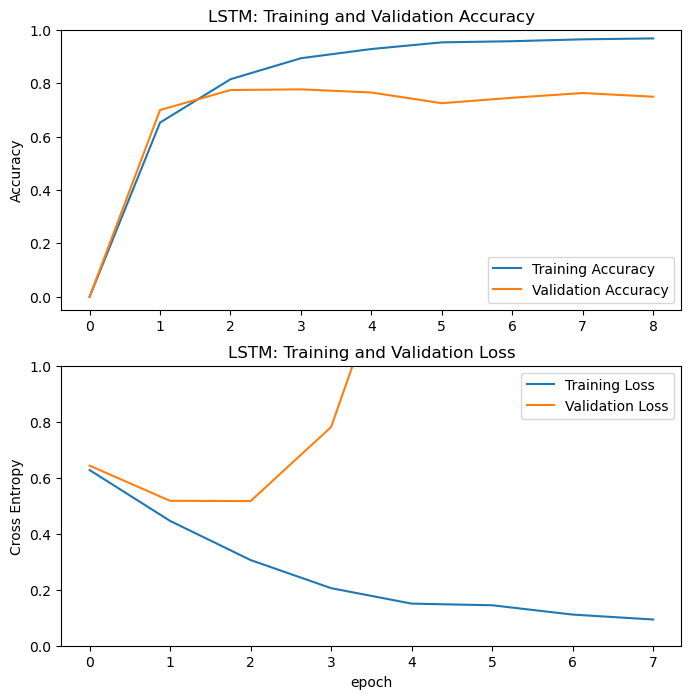

In [98]:
acc_lstm = [0.] + history_lstm.history['accuracy']
val_acc_lstm = [0.] + history_lstm.history['val_accuracy']

loss_lstm = history_lstm.history['loss']
val_loss_lstm = history_lstm.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_lstm, label='Training Accuracy')
plt.plot(val_acc_lstm, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('LSTM: Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_lstm, label='Training Loss')
plt.plot(val_loss_lstm, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('LSTM: Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

For LSTM model, Training Accuracy is coverging at 8the epoch however Validation Accuracy converged much earlier at 3rd Epoch. 

Training Loss continues to fall as we train more epochs however Validation Loss shoots up beyond 2nd Epoch and stays around 1.1 and even increase with every new epoch as we go beyond 10th epoch. 

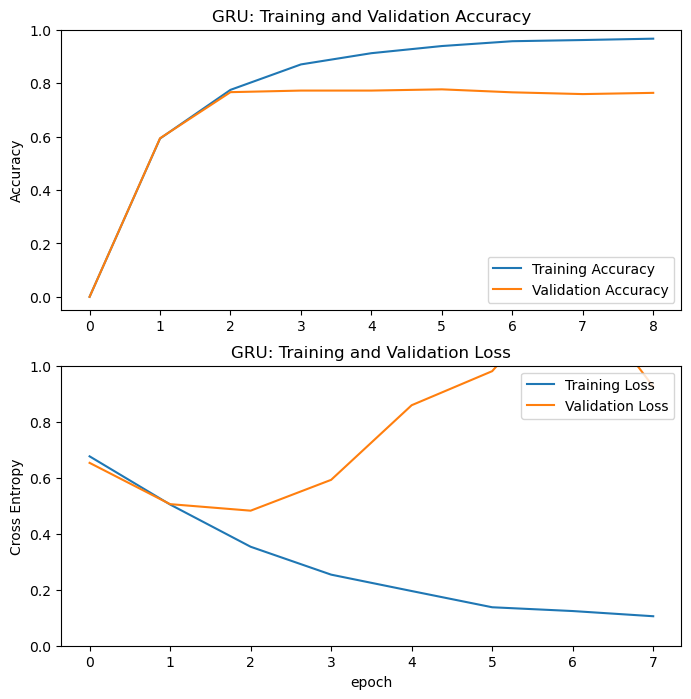

In [99]:
acc_gru = [0.] + history_gru.history['accuracy']
val_acc_gru = [0.] + history_gru.history['val_accuracy']

loss_gru = history_gru.history['loss']
val_loss_gru = history_gru.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_gru, label='Training Accuracy')
plt.plot(val_acc_gru, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('GRU: Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_gru, label='Training Loss')
plt.plot(val_loss_gru, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('GRU: Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Findings of GRU model is mirroing LSTM model with just one difference that rate of increase in Validation Error is slightly lower. However overall both models present same findings, Training Accuracy converging at 8th Epoch and Validation Accuracy converging in 3rd Epoch. Training Error seems to be converging at 8th Epoch but Validation Error will increase as we increase number of epochs.

In [106]:
test_predictions_lstm = model_lstm.predict(test_sequences_pad)
test_predictions_lstm = test_predictions_lstm.flatten()
test_predictions_lstm = np.round(test_predictions_lstm).astype('int')

102/102 [==============================] - 2s 15ms/step


In [109]:
test_predictions_gru = model_gru.predict(test_sequences_pad)
test_predictions_gru = test_predictions_gru.flatten()
test_predictions_gru = np.round(test_predictions_gru).astype('int')

102/102 [==============================] - 2s 16ms/step


In [110]:
#Creating LSTM Submission
submission['target'] = test_predictions_lstm
submission.to_csv('submission.csv', index=False)

In [ ]:
#Creating GRU Submission
submission['target'] = test_predictions_gru
submission.to_csv('submission_gru.csv', index=False)

We obtained LSTM F1 score of 0.76402 and GRU F1 Score of 0.75819. On the basis of this we can say that LSTM is slightly better than the GRU model for our project.

## 6. Conclusion

Both models take similar amount of time to train.

Both models have similar Validation Error and Validation Accuracy.

However both models have different F1 scores, LSTM model has the Test F1 Score of 0.76402 and GRU Model has the Test F1 Score of 0.75819. Even if LSTM has lower Validation Accuracy of 0.7491 compared to GRU's 0.7636 we will consider LSTM to be a better Model here because its working better on test dataset.

So for this project we submitted LSTM as our final model.

If we want to improve the model we will be needded to use unsupervised learning algorithm like GloVe (Global Vectors for Word Representation) along with LSTM and GRU models or use more advanced NLP Architectures. We can also try to improve the current models by adding more Validation samples but using Glove or some better Architecuture than the bidirectional LSTM and GRU seems to be a better bet.